In [23]:
# Using earthaccess access pattern for direct access of cloud-hosted 
# MEaSUREs BedMachine Antarctica bed/ice topography dataset
# Calculates hydropotential fields, flow accumulation, and flow paths 
#
# Code  written to run on CryoCloud cloud-computing JupyterHub
# Learn more: https://cryointhecloud.com/
# 
# Written 2023-11-15 by Wilson Sauthoff (wsauthoff.github.io)

In [2]:
%pip install pysheds

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import earthaccess
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pysheds.grid import Grid
from shapely.geometry import LineString, MultiPoint, Point
import xarray as xr

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/my_repos/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'

# Import datasets

In [4]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [5]:
# Find cloud-hosted BedMachine Antarctica bed/ice geometry dataset, Version 3
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/FPSU0V1MWUB6',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [6]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 1 granules, approx size: 0.79 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>]

In [7]:
# Print file name to ensure expected dataset
print(files[0])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>


In [8]:
# Open file into xarray dataset
bedmachine = xr.open_dataset(files[0])
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [9]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'surface', 'thickness', 'bed']

variables_to_drop = [var for var in bedmachine.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
bedmachine = bedmachine.drop_vars(variables_to_drop)
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [10]:
# Use BedMachine bed topography for Zbed; static BedMachine surface topogrpahy for static Zsurf
rho_water = 997
rho_ice = 917
bedmachine = bedmachine.assign(static_hydropotential_kPa = (9.8 * ((rho_ice*bedmachine['surface']) + (rho_water-rho_ice)*bedmachine['bed']))/1e3)

# Display xarray.Dataset metadata
bedmachine

<xarray.Dataset>
Dimensions:                    (x: 13333, y: 13333)
Coordinates:
  * x                          (x) int32 -3333000 -3332500 ... 3332500 3333000
  * y                          (y) int32 3333000 3332500 ... -3332500 -3333000
Data variables:
    surface                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thickness                  (y, x) float32 ...
    bed                        (y, x) float32 -5.916e+03 ... -3.664e+03
    static_hydropotential_kPa  (y, x) float32 -4.638e+03 ... -2.873e+03
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [11]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [12]:
# Clip BedMachine to grounding line to limit drainage basin delineation to only below grounded ice
# Add 1000 m buffer to grounding line so that branches extend outward from grounding line 
# so that we can find the intersection points of the branches and the grounding line for basin delineation
bedmachine.rio.write_crs("epsg:3031", inplace=True)
bedmachine_clipped = bedmachine.rio.clip(Scripps_landice.geometry.values.buffer(10000), Scripps_landice.crs)

In [24]:
# Detele intermediary file to reduce memory usage
del bedmachine

# Analysis

In [35]:
# Create tif of hydropotential field
# Define array
arr = bedmachine_clipped['static_hydropotential_kPa']

# Write CRS
arr3031 = arr.rio.write_crs("EPSG:3031")

# Specify the output raster file path
output_raster_path = 'temp_raster.tif'

# Convert xarray DataArray to raster and save it
arr3031.rio.to_raster(output_raster_path)

# Initialize a grid and DEM from a raster
grid = Grid.from_raster('temp_raster.tif', nodata=bedmachine_clipped.attrs['no_data'])
dem = grid.read_raster('temp_raster.tif', nodata=bedmachine_clipped.attrs['no_data'])

# Delete temp tif file
os.remove('temp_raster.tif')

# Fill pits in hydropotential DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in hydropotentialDEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in hydropotential DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping for the type of routing algo you wish to use
# dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem)#, dirmap=dirmap)  # Don't specify dirmap to use default dirmap (not sure which this is - D-infinity? D-8?)

# Calculate flow accumulation
acc = grid.accumulation(fdir)#, dirmap=dirmap)

In [36]:
# # To extract river network, you can use a threshold on the flow accumulation
# threshold = 15000  # This value depends on your specific application
# branches = grid.extract_river_network(fdir, acc > threshold)#, dirmap=dirmap)

In [37]:
# Larger basins to finalize method

# To extract river network, you can use a threshold on the flow accumulation
threshold = 30000  # This value depends on your specific application
branches = grid.extract_river_network(fdir, acc > threshold)#, dirmap=dirmap)

In [38]:
# Store
line_strings = []

for branch in branches['features']:
    line_coords = branch['geometry']['coordinates']
    line = LineString(line_coords)
    line_strings.append(line)

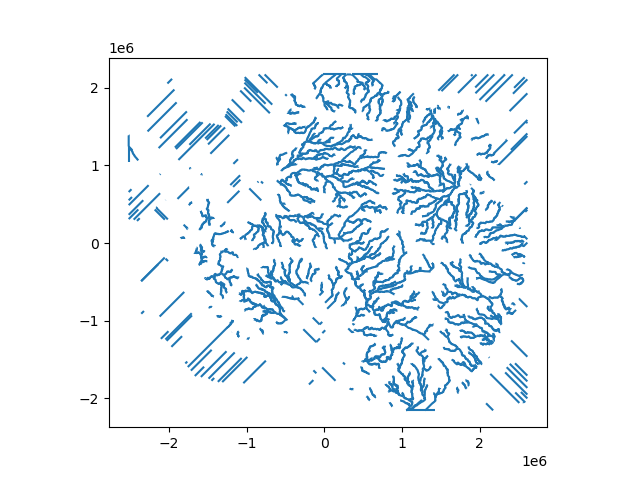

In [39]:
flow_paths_gdf = gpd.GeoDataFrame(geometry=line_strings)
flow_paths_gdf.plot()
plt.show()

In [40]:
# Set the CRS for gdf if it's not set
if flow_paths_gdf.crs is None:
    flow_paths_gdf.set_crs("EPSG:3031", inplace=True)

In [41]:
# Clip flow path branches to grounding line
# Add 1000 m buffer to grounding line so that branches extend outward from grounding line 
# so that we can find the intersection points of the branches and the grounding line for basin delineation
clipped_flow_paths_gdf = gpd.clip(flow_paths_gdf, Scripps_landice.geometry.buffer(10000))

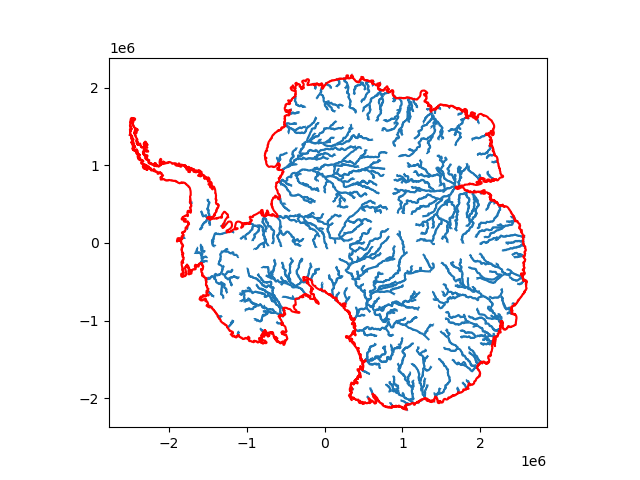

In [42]:
fig, ax = plt.subplots()
clipped_flow_paths_gdf.plot(ax=ax)
Scripps_landice.boundary.plot(ax=ax, color='red')
plt.show()